In [1]:
import pandas as pd 
import numpy as np
from utils import * 
from grid_search_parallelized import GAN,Generator,Discriminator,Params
import json

In [2]:
file_path = 'data_train_log_return.csv'
header = ["stock1", "stock2", "stock3", "stock4"]
df_train = pd.read_csv(file_path, header=None,index_col=0)
df_train.columns = header


In [3]:
with open("submission/model_params.json", "r") as json_file:
    config = json.load(json_file)
    latent_dim = config['latent_dim']
    g_config = config['generator']
    d_config = config['discriminator']

opt = Params()  
opt.latent_dim = latent_dim 
opt.n_epochs =0 ## model weights are already trained

def generate_noise(n_samples):
    covariance_matrix= 0.75 ** np.abs(np.subtract.outer ( np.arange(opt.latent_dim),np.arange (opt.latent_dim)))
    noise = np.random.multivariate_normal(mean=np.zeros(opt.latent_dim),
                                            cov=covariance_matrix,
                                            size=n_samples)
    squared_noise = noise**2
    cube_noise = noise **3
    noise = np.concatenate([noise, squared_noise,cube_noise], axis=1)
    return noise

## build GAN
generator = Generator(latent_dim,output_shape = opt.shape_data, **g_config)

### load weigths
generator.model.load_weights('submission/generator_weights.h5')
discriminator = Discriminator(opt.shape_data,**d_config)
gan = GAN(generator,discriminator,opt)


### import noise
noise = pd.read_csv('submission/noise.csv',index_col=0)
noise = noise.values
synthetic_data = generator.model.predict(noise)
synthetic_data = pd.DataFrame(synthetic_data,columns = df_train.columns) /100 ### divide synthetic data by 100 as we fitted using df_train * 100
synthetic_data

13/13 [==============================] - 0s 994us/step


,stock1,stock2,stock3,stock4
0,0.036150,0.027986,0.005762,0.004549
1,0.064053,0.015040,0.000003,0.000020
2,0.009923,0.015208,0.003571,0.016866
3,0.012089,0.029192,0.003707,0.013426
4,0.016696,0.044588,0.000811,0.011752
...,...,...,...,...
405,0.002982,0.003131,0.010109,0.006859
406,0.006606,0.015269,0.004344,0.010647
407,0.009417,0.015617,0.009077,0.012411
408,0.008333,0.003379,0.005192,0.010587


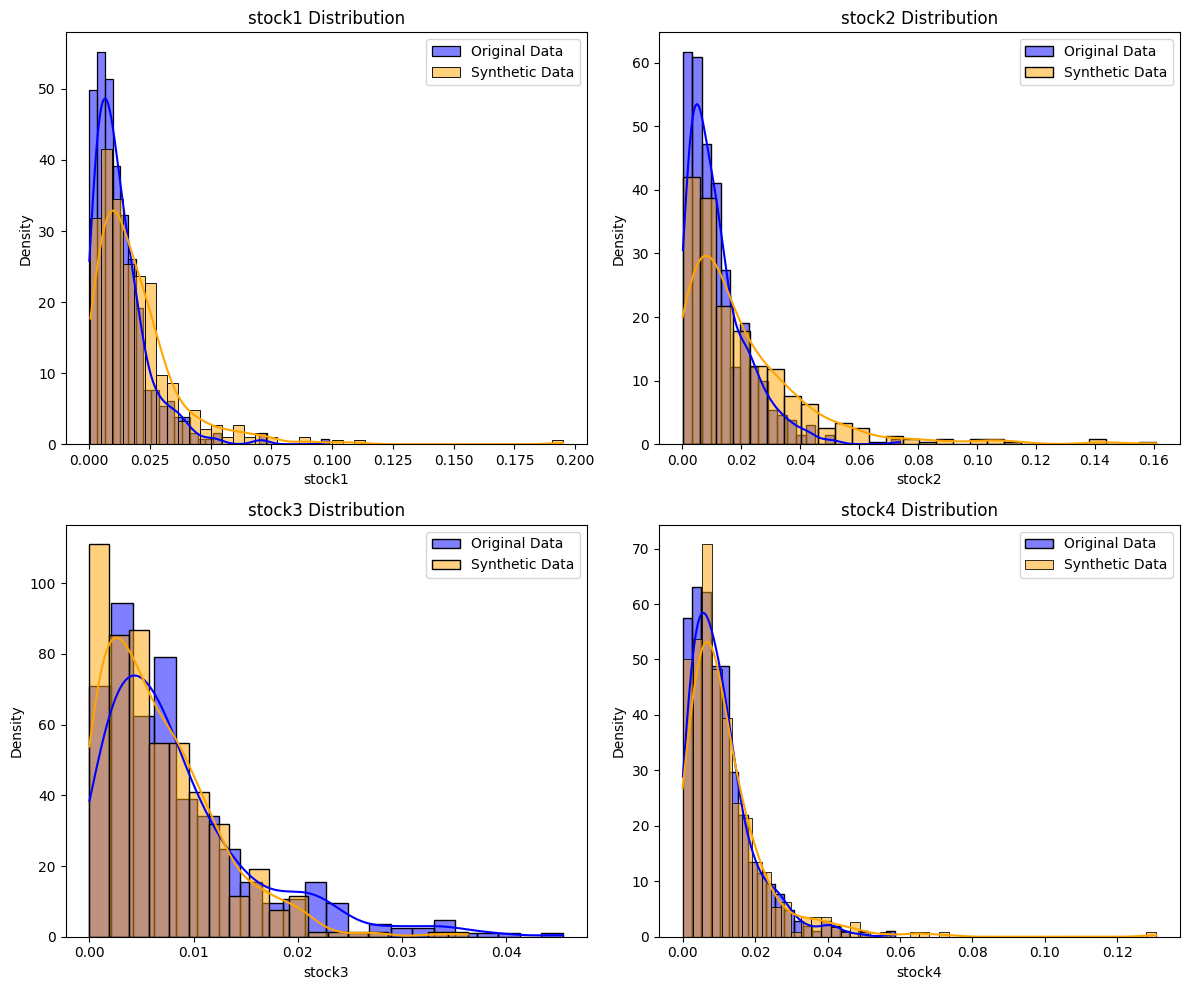

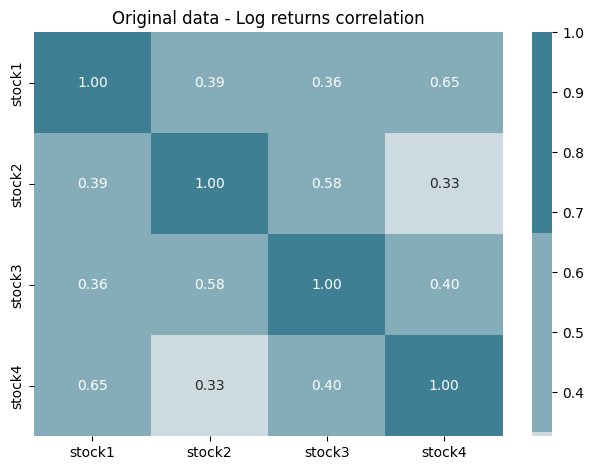

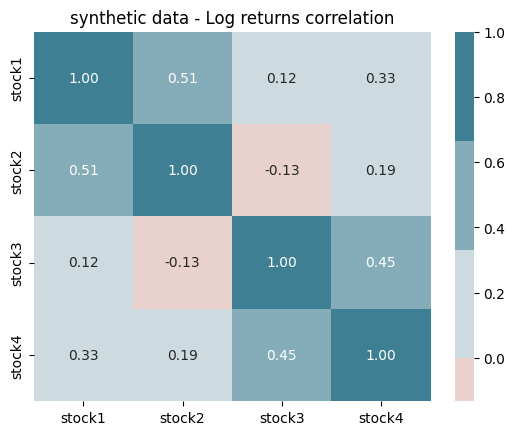

In [4]:
compare(synthetic_data, df_train.sample(410))